In [29]:
# read in data from excel file to dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm
from scipy.stats import t

#===================== Independent Constants =====================
class EnvConstants:
    """Environmental constants for atmospheric and crop conditions with units and descriptions.

    Attributes:
        P (float): Atmospheric pressure (kPa).
        zm (float): Measurement height for wind speed (m).
        k (float): von Karman's constant (none).
        esurface (float): Emissivity of crop (none).
        sigma (float): Stefan-Boltzmann constant (W m-2 K-4).
        KR (int): Parameter in Equ (24.2) (W m-2).
        KD1 (float): Parameter in Equ (24.6) (kPa-1).
        KD2 (float): Parameter in Equ (24.6) (kPa-2).
        TL (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        T0 (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        TH (float): Parameter in Equ (24.4) and Equ (24.5) (K).
        KM1 (float): Parameter in Equ (24.6) (none).
        KM2 (float): Parameter in Equ (24.6) (mm-1).
        rho_a (float): Moist Air density (kg m-3).
        cp (float): Specific heat capacity of air at constant pressure (J kg-1 K-1).
        gc (float): Canopy cover factor (none).
        aT (float): Parameter in temperature stress factor (none).
        zo_prime (float): Aerodynamic roughness of soil (m).
    """
    P: float = 101.20  # Atmospheric pressure
    zm: float = 50.00  # Measurement height for wind speed
    k: float = 0.4  # von Karman's constant
    esurface: float = 0.95  # Emissivity of crop 
    sigma: float = 5.67E-08  # Stefan-Boltzmann constant (W m-2 K-4)
    KR: int = 200  # Parameter in Equ (24.2)
    KD1: float = -0.307  # Parameter in Equ (24.6)
    KD2: float = 0.019  # Parameter in Equ (24.6)
    TL: float = 273.00  # Parameter in Equ (24.4) and Equ (24.5)
    T0: float = 293.00  # Parameter in Equ (24.4) and Equ (24.5)
    TH: float = 313.00  # Parameter in Equ (24.4) and Equ (24.5)
    KM1: float = 3.36E-04  # Parameter in Equ (24.6)
    KM2: float = -0.10  # Parameter in Equ (24.6)
    rho_a: float = 1.23  # Moist Air density
    cp: float = 1013.00  # Specific heat capacity of air
    gc: float = 1.00  # Canopy cover factor
    aT: float = 1.00  # Parameter in temperature stress factor
    zo_prime: float = 0.003  # Aerodynamic roughness of soil

#===================== Crop Dependent Constants =====================

class ForestConstants:
    """Forest environmental constants with units and descriptions.

    Attributes:
        LAI (float): Leaf Area Index (none).
        h (float): Canopy Height (m).
        a (float): Albedo (none).
        g0 (float): Canopy Specific Constant (mm s-1).
        SMo (float): Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
        SMinit (float): Initial Root-accessible soil moisture (mm).
        S (float): Maximum Canopy Water Storage (mm).
        d (float): Zero plane displacement height (m).
        z0 (float): Aerodynamic roughness of crop (m).
    """
    LAI: float = 4.00  # Leaf Area Index
    h: float = 20.00  # Canopy Height
    a: float = 0.12  # Albedo
    g0: float = 15.00  # Canopy Specific Constant
    SMo: float = 80.00  # Maximum soil moisture accessible to roots
    SMinit: float = 40.00  # Initial Root-accessible soil moisture
    S: float = 4.00  # Maximum Canopy Water Storage
    d: float = 14.644  # Zero plane displacement height
    z0: float = 1.607  # Aerodynamic roughness of crop
    LW_up_init: float = 350.00  # Initial upward longwave radiation (W m-2)

class GrassConstants:
    """Grass environmental constants with units and descriptions.

    Attributes:
        LAI (float): Leaf Area Index (none).
        h (float): Canopy Height (m).
        a (float): Albedo (none).
        g0 (float): Canopy Specific Constant (mm s-1).
        SMo (float): Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
        SMinit (float): Initial Root-accessible soil moisture (mm).
        S (float): Maximum Canopy Water Storage (mm).
        d (float): Zero plane displacement height (m).
        z0 (float): Aerodynamic roughness of crop (m).
    """
    LAI: float = 2.00  # Leaf Area Index
    h: float = 0.12  # Canopy Height
    a: float = 0.23  # Albedo
    g0: float = 30.00  # Canopy Specific Constant
    SMo: float = 40.00  # Maximum soil moisture accessible to roots
    SMinit: float = 10.00  # Initial Root-accessible soil moisture
    S: float = 2.00  # Maximum Canopy Water Storage
    d: float = 0.077  # Zero plane displacement height
    z0: float = 0.013  # Aerodynamic roughness of crop
    LW_up_init: float = 319.00  # Initial upward longwave radiation (W m-2)

#==================== Model forcing data ==========================
excel_file = "Lab1.xlsx"
# Read the data from the Excel file, skipping rows so that headers start from row 11 (indexing starts from 0)
forest_data = pd.read_excel(excel_file, header=0, sheet_name = "Forest", skiprows=10)
grass_data = pd.read_excel(excel_file, sheet_name="Grass", header=0, skiprows=10) 


c:\Users\adunw\miniconda3\envs\EcoHydro\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\adunw\miniconda3\envs\EcoHydro\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [30]:
# Part A: Aerodynamic Parameterization. 

def calc_d(h, LAI):
    """
    Calculate zero plane displacement height using constants from either ForestConstants or Grasscrop_constants.
    (TH Eq 22.2)
    :param h: Canopy height (m). Crop constant.
    :param LAI: Leaf Area Index (none). Crop constant.
    :return: Zero plane displacement height (m).
    """
    return 1.1 * h * np.log(1 + (LAI / 5)**0.25)  # TH Eq 22.2

def calc_zo(h, d, LAI):
    """
    Calculate aerodynamic roughness of crop. (TH Eq 22.3, 22.4) 
    :param h: Canopy height (m). Crop constant.
    :param d: Zero plane displacement height (m).
    :param LAI: Leaf Area Index (none). Crop constant.
    :return: Aerodynamic roughness of crop (m).
    """

    if LAI > 1:
        return 0.3 * h * (1 - d / h)  # TH Eq 22.4
    else:
        return EnvConstants.zo_prime + 0.29 * h * (LAI / 5) ** 0.5  # TH Eq 22.3

def calc_ra(d, zo, um):
    """
    Calculate aerodynamic resistance using constants from Environmentalcrop_constants.
    (TH Eq 22.1)
    :param zm: Measurement height for wind speed (m). Environmental constant.
    :param d: Zero plane displacement height (m).
    :param zo: Aerodynamic roughness of crop (m).
    :param um: Wind speed at measurement height (m s-1).
    :param k: von Karman's constant (none). Environmental constant.
    :return: Aerodynamic resistance (s m-1).
    """
    k = EnvConstants.k
    zm = EnvConstants.zm
    return 1 / (k**2 * um) * np.log((zm - d) / zo)**2  # TH Eq 22.1



In [31]:
# Part B: Surface Resistance Parameterization

def calc_gR(SW_in):
    """
    Calculate resistance to soil heat flux (Eq. 24.2 in TH)
    :param SW_in: Incoming shortwave radiation (W m-2).
    :param KR: Parameter in Equ (24.2) (W m-2). Environemntal constant.
    :return: Resistance to soil heat flux (none).
    """
    KR = EnvConstants.KR
    gR =  SW_in * (1000 + KR) / (1000 * (SW_in + KR)) # Eq. 24.2 TH
    return max(gR, 0.)  

def calc_gD(D):
    """
    Calculate resistance to vapor pressure deficit (Eq. 24.3 in TH)
    :param D: Vapor pressure deficit (kPa).
    :param KD1: Parameter in Equ (24.6) (kPa-1). Environemntal constant.
    :param KD2: Parameter in Equ (24.6) (kPa-2). Environemntal constant.
    :return: Resistance to vapor pressure deficit (none).
    """
    KD1 = EnvConstants.KD1
    KD2 = EnvConstants.KD2
    gD = 1 + KD1 * D + KD2 * D**2 # Eq. 24.3 TH
    return max(gD, 0.)  
    
def calc_gT(T):
    """
    Calculate resistance to temperature (Eq. 24.4 in TH)
    :param T: Temperature (K).
    :param TL: Parameter in Equ (24.4) and Equ (24.5) (K). Environemntal constant.
    :param T0: Parameter in Equ (24.4) and Equ (24.5) (K). Environemntal constant.
    :param TH: Parameter in Equ (24.4) and Equ (24.5) (K). Environemntal constant.
    :param aT: Parameter in temperature stress factor (none). Environemntal constant.
    :return: Resistance to temperature (none).
    """
    TL = EnvConstants.TL
    T0 = EnvConstants.T0
    TH = EnvConstants.TH
    aT = EnvConstants.aT
    gT = ((T - TL) * (TH - T)**aT) / ((T0 - TL) * (TH - T0)**aT) # Eq. 24.4 TH, problem statemnt B.1
    return max(gT, 0.)  

def calc_gSM(SM, SMo): 
    """
    Calculate resistance to soil moisture flux (Eq. 24.6 in TH)
    :param SM: Soil moisture (mm).
    :param SMo: Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm).
    :param KM1: Parameter in Equ (24.6) (none). Environemntal constant.
    :param KM2: Parameter in Equ (24.6) (mm-1). Environemntal constant.
    :return: Resistance to soil moisture flux (none).
    """
    KM1 = EnvConstants.KM1
    KM2 = EnvConstants.KM2
    
    gSM = 1 - KM1 * np.exp(KM2 * (SM - SMo))  # Eq. 24.6 TH
    return max(gSM, 0.)  

def calc_gs(gR, gD, gT, gSM, g0):
    """
    Calculate total surface conductance (Eq. 24.1 in TH)
    :param gR: Resistance to soil heat flux (none).
    :param gD: Resistance to vapor pressure deficit (none).
    :param gT: Resistance to temperature (none).
    :param gSM: Resistance to soil moisture flux (none).
    :param g0: Canopy Specific Constant (mm s-1). Crop constant.
    :return: Total surface conductance (mm s-1).
    """
    gs = (gR * gD * gT * gSM * g0) # Eq. 24.1 TH
    return max(gs, 10**-4)  

def calc_rs(gs):
    """
    Calculate total surface resistance (Eq. 24.1 in TH)
    :param gs: Total surface conductance (mm s-1).
    :return: Total surface resistance (s mm-1).
    """
    rs = 1 / gs # Eq. 24.1 TH
    return min(rs, 10**4)  
    
def calc_esat(T):
    """
    Calculate saturation vapor pressure from temperature (Eq. 2.17 in TH)
    :param T: Temperature (K).
    :return: Saturation vapor pressure (kPa).
    """
    esat = 0.6108 * np.exp(17.27 * T / (T + 237.3)) # Eq. 2.17 TH
    return esat

def calc_e(q):
    """
    Calculate vapor pressure from specific humidity and pressure (Eq. 2.9 in TH)
    :param q: Specific humidity (kg kg-1).
    :param P: Atmospheric pressure (kPa). Environemntal constant.
    :return: Vapor pressure (kPa).
    """
    P = EnvConstants.P
    e = P * q / 0.622 # Eq 2.9 TH
    return e

def calc_D(esat, e):
    """
    Calculate vapor pressure deficit (Eq. 2.10 in TH)
    :param esat: Saturation vapor pressure (kPa).
    :param e: Vapor pressure (kPa).
    :return: Vapor pressure deficit (kPa).
    """
    D = esat - e # Eq 2.10 TH
    return D


In [32]:
#Part C: Radiation Parameterization

def calc_Ts(Ta, H, ra):
    """
    Calculate surface temperature (Eq. 21.30 in TH)
    :param Ta: Air temperature (K).
    :param H: Sensible heat flux (W m-2).
    :param ra: Aerodynamic resistance (s m-1).
    :param rho_a: Moist Air density (kg m-3). Environmental Constant.
    :param cp: Specific heat capacity of air (J kg-1 K-1). Environmental Constant.
    :return: Surface temperature (K).
    """
    cp = EnvConstants.cp
    rho_a = EnvConstants.rho_a
    Ts = Ta + (H *ra / rho_a / cp) # Eq 21.30 TH
    return Ts

def calc_LW_up(Ts_1, Ts_2):
    """
    Calculate long wave radiation from surface temperature and emissivity. (Eq 5.19 in TH)
    :param T_s: Surface temperature (K).
    :param emissivity: Emissivity of crop (none). Environmental constant.
    :param sigma: Stefan-Boltzmann constant (W m-2 K-4). Environmental constant.
    :return: Long wave radiation from surface (W m-2).
    """
    sigma = EnvConstants.sigma
    emissivity = EnvConstants.esurface
    LW_up = emissivity * sigma * (Ts_1**4 + Ts_2**4)/2 # Modified Eq 5.19 TH (Problem statement C.2)
    return LW_up

def calc_Rn(SW_in, a, LW_up, LW_down):
    """
    Calculate net radiation (Eq 5.28 in TH)
    :param SW_in: Incoming shortwave radiation (W m-2).
    :param a: Albedo (none). Crop Constant.
    :param LW_up: Long wave radiation from surface (W m-2).
    :param LW_down: Long wave radiation from atmosphere (W m-2).
    :return: Net radiation (W m-2).
    """
    LW_net = LW_down - LW_up
    Rn = (1 - a) * SW_in + LW_net # Eq 5.28 TH
    return Rn

In [33]:


#Part D.1 Canopy Water Balance Parameterization (Includes Interception) 

def calc_delta(T, e_sat): 
    """
    Calculate gradient of the saturation vapor pressure curve from saturation vapor pressure and temperature
    (Eq 2.18 in TH)
    e_sat: saturation vapor pressure in kPa
    T: temperature in degrees Celsius
    return: slope of the saturation vapor pressure curve in kPa/°C
    """

    delta = 4098 * e_sat / (T + 237.3)**2 # Eq 2.18 TH, problem statement D.1.1
    return delta

def calc_LH(T):
    """
    Calculate latent heat of vaporization from temperature (Eq 2.1 in TH)
    T: temperature in degrees Celsius
    return: latent heat of vaporization (lambda) in MJ/kg
    """
    LH = 2.501 - 0.002361 * T # Eq 2.1 TH, problem statement D.1.1
    return LH

def calc_psy_const(LH):
    """
    Calculate psychrometric constant (Eq 2.25 in TH)
    c_p: specific heat of dry air at constant pressure in kJ/kg/K
    P: pressure in kPa
    LH: latent heat of vaporization in MJ/kg
    return: psychrometric constant in kPa/°C
    """
    cp = EnvConstants.cp / 1000 # convert from kJ/kg/K to MJ/kg/K
    P = EnvConstants.P
    psychrometric_constant = cp * P / (0.622 * LH) # Eq. 2.25 TH, problem statement D.1.1
    return psychrometric_constant

def calc_Cinterim(p, Cfinal):
    """
    Calculate interim canopy drainage (D.1.6 in problem statement)
    :param p: precipitation in mm
    :param Cfinal: final canopy storage in mm
    return: interim canopy storage in mm
    """
    Cinterim = p + Cfinal # Given in problem statement D.1.6
    # Ensure postive value
    return max(Cinterim, 0)

def calc_Cactual(Cinterim, S):
    """
    Calculate actual canopy storage for each row.
    :param Cinterim: interim canopy storage in mm
    :param S: maximum canopy storage in mm
    :return: actual canopy storage in mm
    """

    if Cinterim > S: 
        return S
    else:
        return Cinterim

def calc_Dcanopy(Cinterim, S):
    """
    Calculate canopy drainage for each row.
    :param Cinterim: interim canopy storage in mm
    :param S:  maximum canopy storage in mm
    :return: canopy drainage in mm
    """
    Dcanopy = max(Cinterim - S, 0)  # Ensure Dcanopy is not negative
    return Dcanopy


def calc_Cfinal(lambdaEl, Cactual, LH):
    """
    Calculate final canopy storage
    :param lambdaEl: evaporation rate of intercepted rainfall with free water canopy in W m-2
    :param Cactual: actual canopy storage in mm
    :param LH: latent heat of vaporization in MJ/kg
    return: final canopy storage in mm
    """
    lambdaEl_mm = lambdaEl * 3600 / LH # Convert from W m-2 to mm/h
    Cfinal = Cactual - lambdaEl_mm # Problem statement D.1.9
    return max(Cfinal,0)

def calc_dCdt(p, lambdaEl, D):
    """
    Calculate change in canopy drainage with respect to time (Eq 22.15 in TH)
    :param p: precipitation in mm
    :param lambdaEl: evaporation rate of intercepted rainfall with free water canopy in W m-2
    :param D: vapor pressure deficit in kPa
    return: change in canopy drainage with respect to temperature in mm/h
    """
    ft = 0
    fs = 0
    dCdT = p*(1 - ft - fs) - lambdaEl - D # Eq 22.15 TH, problem statement D.1.3
    return dCdT

def calc_lambdaEl(delta, ra, Rn, psy_const, D, C, S):
    """
    Calculate evaporation rate of intercepted rainfall with free water canopy (Eq 22.14 in TH)
    :param delta: slope of the saturation vapor pressure curve in kPa/°C
    :param ra: aerodynamic resistance in s/m
    :param Rn: net radiation in W/m^2
    :param psy_const: psychrometric constant in kPa/°C
    :param rho_a: moist air density in kg/m^3. Environmental constant.
    :param D: vapor pressure deficit in kPa
    return: evaporation rate of intercepted rainfall with free water canopy in W m-2
    """
    
    A = Rn # Available energy = net radiation problem statement D.1.8
    Dref = D # VPD at reference level above canopy in kPa
    rho_a = EnvConstants.rho_a
    cp = EnvConstants.cp
    lambdaEl = C / S * delta * A + (rho_a * cp * Dref / ra) / (delta + psy_const) # Eq 22.14 TH, problem statement D.1.4
    return lambdaEl

def calc_lambdaET(delta, Rn, D, psy_const, rs, ra):
    """
    Calculate transpiration rate (Eq 22.16 in TH)
    :param delta: slope of the saturation vapor pressure curve in kPa/°C
    :param Rn: net radiation in W/m^2
    :param D: vapor pressure deficit in kPa
    :param psy_const: psychrometric constant in kPa/°C
    :param ra: aerodynamic resistance in s/m
    return: transpiration rate in W m-2
    """
    A = Rn # Available energy = net radiation problem statement D.1.8
    Dref = D # VPD at reference level above canopy in kPa
    rho_a = EnvConstants.rho_a
    cp = EnvConstants.cp
    lambdaET = delta * A + (rho_a * cp * Dref / ra) / (delta + psy_const * (1 + rs / ra)) # Eq 22.16 TH, problem statement D.1.5
    return lambdaET

def calc_lambdaE(lambdaEl, C, S, lambdaET):
    """
    Calculate total evaporation rate (Eq 22.17 in TH)
    :param lambdaEl: evaporation rate of intercepted rainfall with free water canopy in W m-2
    :param C: canopy storage in mm
    :param S: maximum canopy storage in mm
    :param lambdaET: transpiration rate in W m-2
    return: total evaporation rate in W m-2
    """
    lambdaE = lambdaEl + (1 - C/S) * lambdaET # Eq 22.17 TH, problem statement D.1.2
    return lambdaE

def calc_H(R_n, lambdaE):
    """
    Calculate turbulent sensible heat flux from net radiation, evaporation rate, and heat flux into the ground.
    (D.1.1 & D.1.12 in problem statement)
    :param R_n: Net radiation (W m-2).
    :param lambdaE: Evaporation rate (W m-2).
    return: Sensible heat flux (W m-2).
    """
    H = H = R_n - lambdaE # Given in problem statement D.1.1 & D.1.12
    return H


In [34]:
# Part E Soil Water Balance Parameterization

def calc_SMnew(Dcanopy, Cactual, S, lambdaET, SMo):
    """
    Calculate new soil moisture (E.1 & E.2 in problem statement)
    :param SMlast: Previous soil moisture (mm).
    :param Dcanopy: Canopy water storage change (mm).
    :param Cactual: Actual canopy water storage (mm).
    :param S: Maximum canopy water storage (mm). Crop constant.
    :param lambdaET: Evapotranspiration (mm).
    :param SMo: Maximum soil moisture accessible to roots (mm). Crop constant.
    :return: New soil moisture (mm).
    """
    SMnew = Dcanopy - (1 - Cactual / S) * lambdaET # problem statement E.1
    # Ensure SMnew does not exceed soil moisture holding capacity
    SMnew = min(SMnew, SMo) #problem statement E.2
    return max(SMnew,0)


In [35]:
def run_model(data, crop_constants):
    """
    Run the model on the given dataset using functions defined above.
    Write the results to a csv file.

    :param data: DataFrame containing either crop data.
    :param crop_constants: Dictionary of constants specific to the crop.
    """
    S = crop_constants.S # Maximum Canopy Water Storage (mm)
    h = crop_constants.h # Canopy Height (m)
    LAI = crop_constants.LAI # Leaf Area Index (none)
    a = crop_constants.a # Albedo (none)
    g0 = crop_constants.g0 # Canopy Specific Constant (mm s-1)
    SMo = crop_constants.SMo # Maximum soil moisture accessible to roots. Parameter in Equ (24.6) (mm)
    SMinit = crop_constants.SMinit # Initial Root-accessible soil moisture (mm)

    data['q'] = data['q'] / 1000 # Convert specific humidity from g/kg to kg/kg
    data['Tk'] = data['Ta'] + 273.17 # Convert temperature from Celsius to Kelvin
    
    # Part A: Aerodynamic Parameterization
    data['d'] = calc_d(h, LAI) # A.1
    data['z0'] = calc_zo(h, data['d'], LAI) # A.1
    data['ra'] = calc_ra(data['d'], data['z0'], data['um']) # A.2
    
    # Part B: Surface Resistance Parameterization
    data['esat(T)'] = calc_esat(data['Ta']) 
    data['e'] = calc_e(data['q'])
    data['D'] = calc_D(data['esat(T)'], data['e'])

    # D.1 Canopy Water Balance Parameterization
    data['delta'] = calc_delta(data['Ta'], data['esat(T)']) #D.1.1
    data['LH'] = calc_LH(data['Ta']) #D.1.1
    data['psy_const'] = calc_psy_const(data['LH']) #D.1.1
    
    #set first two values of LW_up to initial value
    data.at[0, 'LW_up'] = crop_constants.LW_up_init
    data.at[1, 'LW_up'] = crop_constants.LW_up_init

    for index in range(len(data)):

        # Current values for the row
        LH = data.at[index, 'LH'] # Latent heat of vaporization
        delta = data.at[index, 'delta'] # Slope of the saturation vapor pressure curve
        ra = data.at[index, 'ra'] # Aerodynamic resistance
        psy_const = data.at[index, 'psy_const']  # Psychrometric constant 
        D = data.at[index, 'D'] # Current vapor pressure deficit
        p = data.at[index, 'p']  # Current precipitation
        Tk = data.at[index, 'Tk']  # Current temperature
        SW_in = data.at[index, 'SW_in']  # Incoming shortwave radiation
        LW_down = data.at[index, 'LW_down']  # Long wave radiation from atmosphere
        
        if index == 0:
            SMlast= SMinit
            data.at[index, 'SM'] = SMlast
            Cfinal_last = 0
            data.at[index, 'Cfinal'] = Cfinal_last
        else:
            SMlast = data.at[index - 1, 'SM']
            Cfinal_last = data.at[index - 1, 'Cfinal']


        #Part C: Radiation Parameterization
        if index > 1:
            Ts_1 = data.at[index - 1, 'Ts']
            Ts_2 = data.at[index - 2, 'Ts']
            data.at[index, 'LW_up'] = calc_LW_up(Ts_1, Ts_2)

        LW_up = data.at[index, 'LW_up']  # Upward longwave radiation
        data.at[index, 'Rn'] = calc_Rn(SW_in, a, LW_up, LW_down)
        Rn = data.at[index, 'Rn']  # Net radiation

        gR = calc_gR(SW_in)
        gD = calc_gD(D)
        gT = calc_gT(Tk)
        gSM = calc_gSM(SMlast, SMo)
        gs = calc_gs(gR, gD, gT, gSM, g0)
        rs = calc_rs(gs)
        
        C = S # Canopy storage is initially full
        lambdaEl_CS = calc_lambdaEl(delta, ra, Rn, psy_const, D, C, S) #D.1.4 Calculate lambdaEl with C/S = 1
        Cinterim = calc_Cinterim(p, Cfinal_last)
        Cactual = calc_Cactual(Cinterim, S)
        Dcanopy = calc_Dcanopy(Cinterim, S)
        lambdaEl_Cactual = calc_lambdaEl(delta, ra, Rn, psy_const, D, Cactual, S)
        lambdaET = calc_lambdaET(delta, Rn, D, psy_const, rs, ra)
        lambdaE = calc_lambdaE(lambdaEl_Cactual, Cactual, S, lambdaET)
        H = calc_H(Rn, lambdaE)

        # Wet canopy water balance
        dCdt = calc_dCdt(p, lambdaEl_Cactual, Dcanopy) # Problem statement D.1.3
        

        # Update the DataFrame with the calculated values for the current row
        
        data.at[index, 'gR'] = gR
        data.at[index, 'gD'] = gD
        data.at[index, 'gT'] = gT
        data.at[index, 'gSM'] = gSM
        data.at[index, 'gs'] = gs
        data.at[index, 'rs'] = rs
        data.at[index, 'LW_up'] = LW_up
        data.at[index, 'Cinterim'] = Cinterim # Problem statement D.1.6
        data.at[index, 'Cactual'] = Cactual  # Problem statement D.1.7
        data.at[index, 'Dcanopy'] = Dcanopy # Problem statement D.1.7
        data.at[index, 'lambdaEl (C=S)'] = lambdaEl_CS # Problem statement D.1.4
        data.at[index, 'lambdaEl (C=Cactual)'] = lambdaEl_Cactual # Problem statement D.1.8
        data.at[index, 'lambdaET'] = lambdaET # Problem statement D.1.10
        data.at[index, 'lambdaE'] = lambdaE # Problem statement D.1.11
        data.at[index, 'H'] = H # Problem statement D.1.12
        data.at[index, 'dCdt'] = dCdt
        data.at[index, 'Ts'] = calc_Ts(Tk, H, ra)

        if index > 0:
            SM = calc_SMnew(Dcanopy, Cactual, S, lambdaET, SMo)
            Cfinal = calc_Cfinal(lambdaEl_Cactual, Cactual, LH)
            data.at[index, 'SM'] = SM
            data.at[index, 'Cfinal'] = Cfinal # Problem statement D.1.9
            
        
    data.to_csv('processed_forest_data.csv', index=False)
       

forest_constants = ForestConstants("""  """)
grass_constants = GrassConstants()
# Example usage with the provided datasets
run_model(forest_data, forest_constants)
run_model(grass_data, grass_constants)

# After processing, you can export the modified datasets to CSV files
forest_data.to_csv('processed_forest_data.csv', index=False)
grass_data.to_csv('processed_grass_data.csv', index=False)




In [36]:
#Plot the data
def plot_data(df):
    """
    Plot the processed data from the forest dataset.
    :param df: DataFrame containing the processed forest data.
    """
    # Plot gR wide layout with y min of 0
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['gR'], label='gR')
    ax.set_title('gR')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('gR')
    ax.legend()
    plt.show()

    #Plot gD wide layout with y min of 0
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['gD'], label='gD')
    ax.set_title('gD')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('gD')
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

    #Plot gT wide layout
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['gT'], label='gT')
    ax.set_title('gT')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('gT')
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

    #Plot Hourly values of the calculated net radiation, total latent heat flux, and sensible  heat flux (all in W m-2) on the same graph
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['Rn'], label='Net Radiation')
    ax.plot(df['lambdaE'], label='Total Latent Heat Flux')
    ax.plot(df['H'], label='Sensible Heat Flux')
    ax.set_title('Radiation Budget')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('W m-2')
    ax.legend()
    plt.show()

    # Plot Hourly values of the calculated total latent heat flux and the portion of the latent heat flux that originates from the evaporation of intercepted water (both in W m-2).

    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['lambdaE'], label='Total Latent Heat Flux')
    ax.plot(df['lambdaEl (C=Cactual)'], label='Intercepted Water Evaporation')
    ax.set_title('Latent Heat Flux')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('W m-2')
    ax.legend()
    plt.show()

    # Plot Hourly values of the precipitation and the canopy storage C (both in mm)
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['p'], label='Precipitation')
    ax.plot(df['Cfinal'], label='Canopy Storage')
    ax.set_title('Precipitation and Canopy Storage')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('mm')
    ax.legend()
    plt.show()

    # Plot Hourly values of the canopy drainage and the value of SM (both in mm)
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['Dcanopy'], label='Canopy Drainage')
    ax.plot(df['SM'], label='Soil Moisture')
    ax.set_title('Canopy Drainage and Soil Moisture')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('mm')
    ax.legend()
    plt.show()

    # Plot Hourly values of the soil moisture stress function gM (no units)
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(df['gSM'], label='Soil Moisture Stress')
    ax.set_title('Soil Moisture Stress')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('dimensionless')
    ax.legend()
    plt.show()


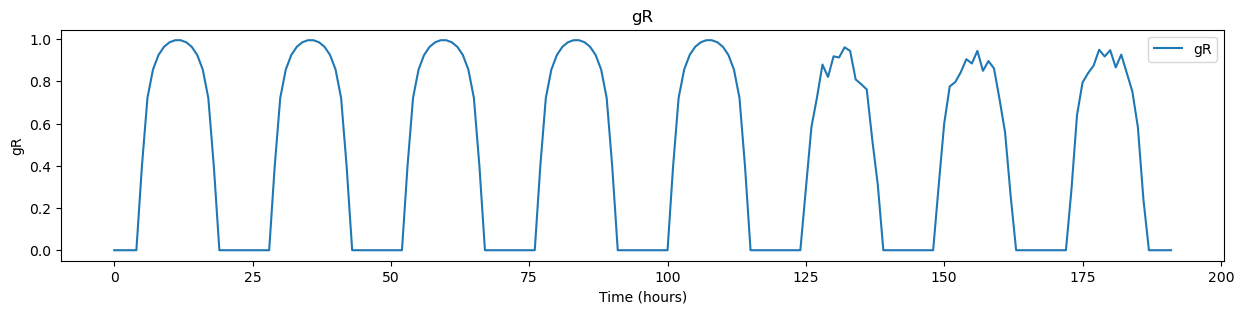

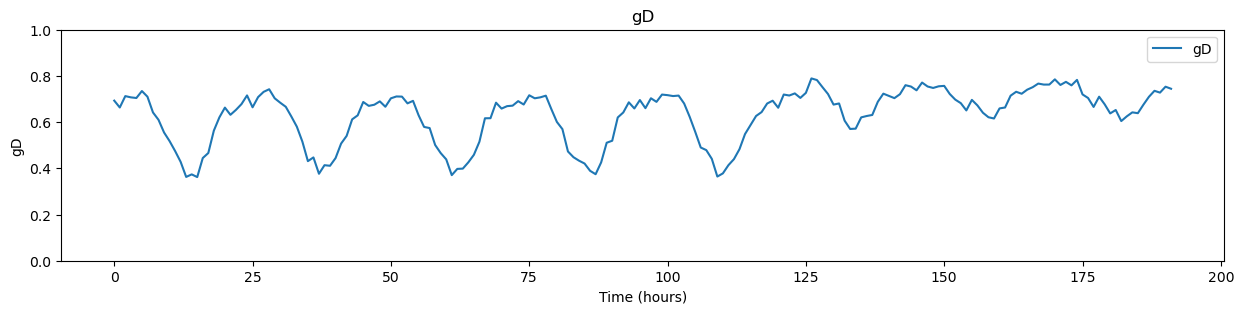

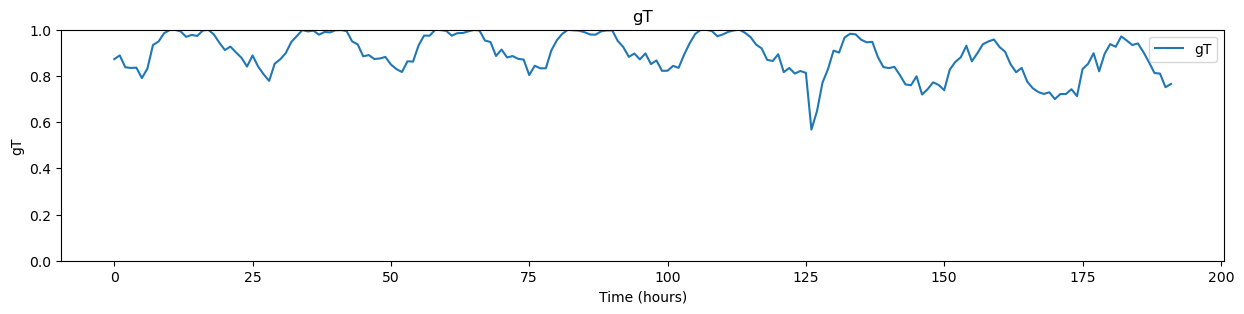

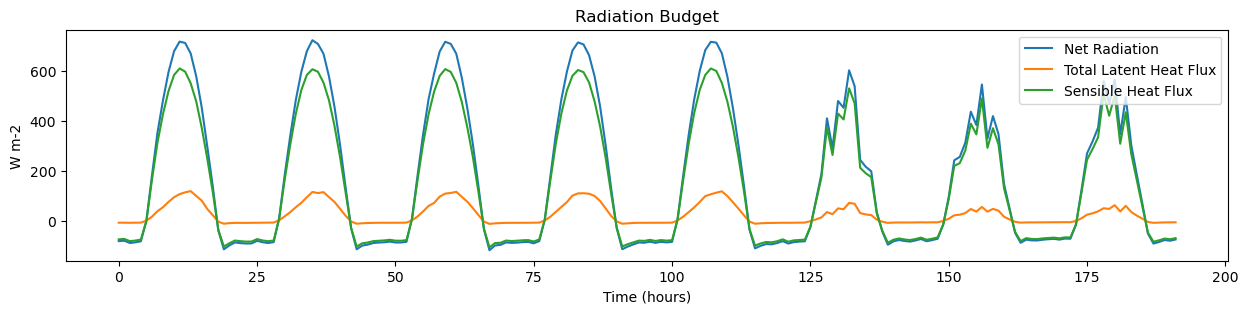

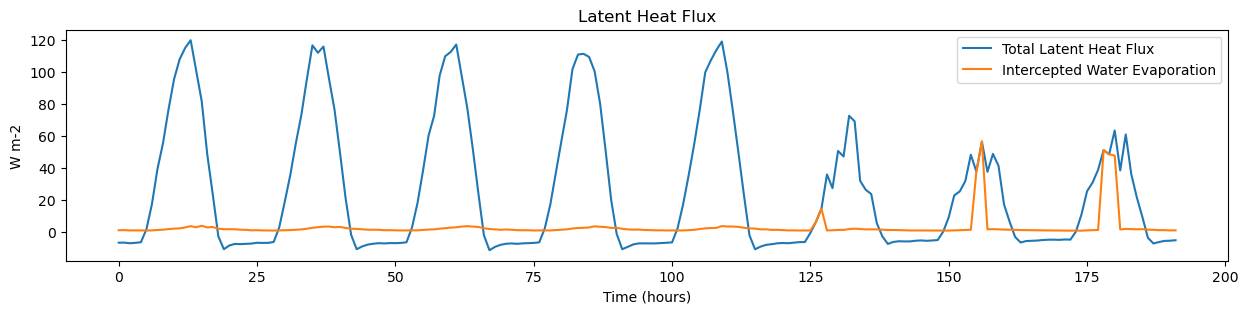

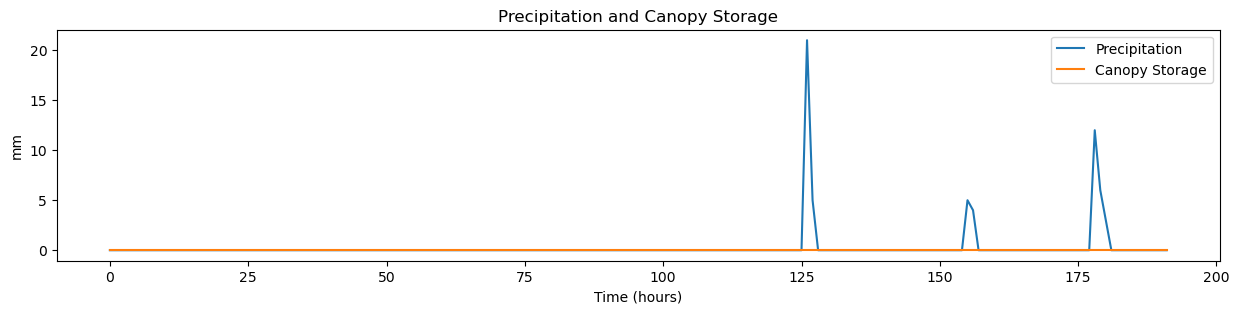

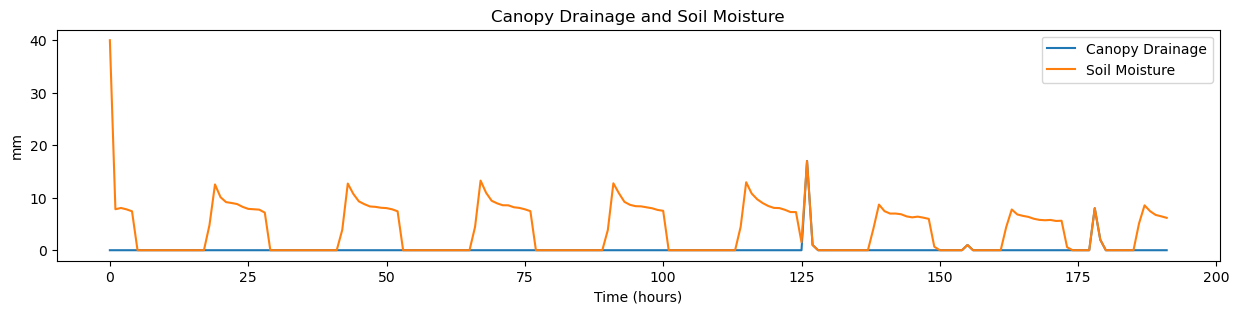

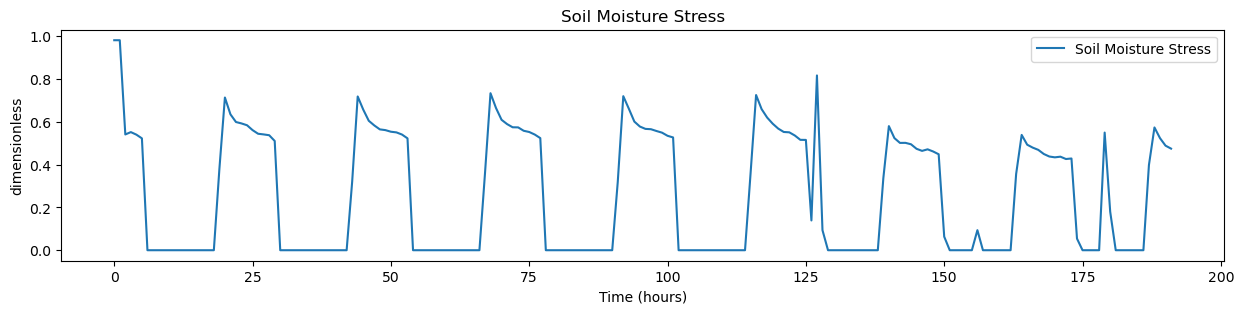

,Day,Rn,lambdaE,H,lambdaEl (C=Cactual),Bowen Ratio,Fractional Contribution
0,0,206.07,33.29,172.78,1.61,5.19,0.05
1,1,206.05,32.68,173.37,1.57,5.30,0.05
2,2,205.44,33.10,172.33,1.63,5.21,0.05
3,3,205.25,32.91,172.34,1.58,5.24,0.05
4,4,206.02,32.83,173.19,1.62,5.28,0.05
5,5,118.63,14.05,104.58,1.78,7.44,0.13
6,6,114.18,13.30,100.88,4.73,7.59,0.36
7,7,135.70,15.52,120.18,6.93,7.74,0.45


In [37]:
plot_data(forest_data)

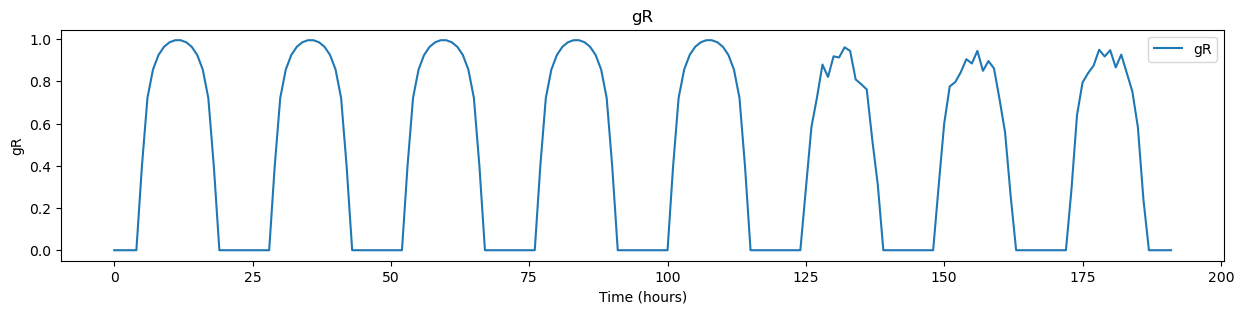

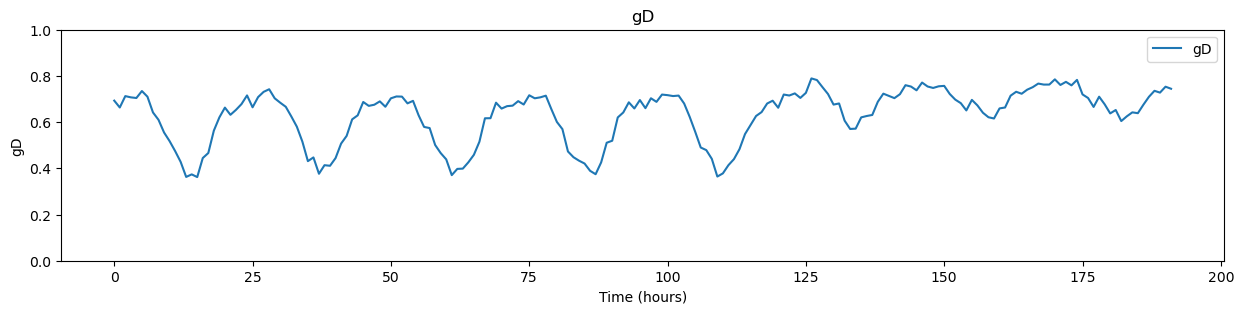

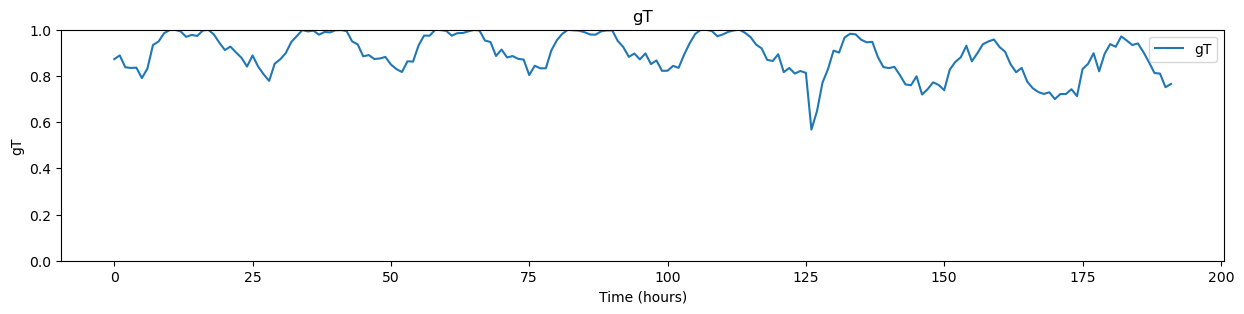

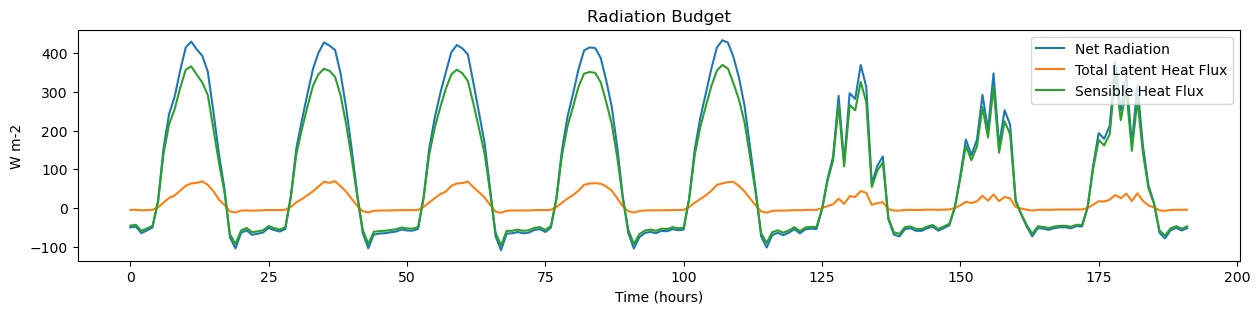

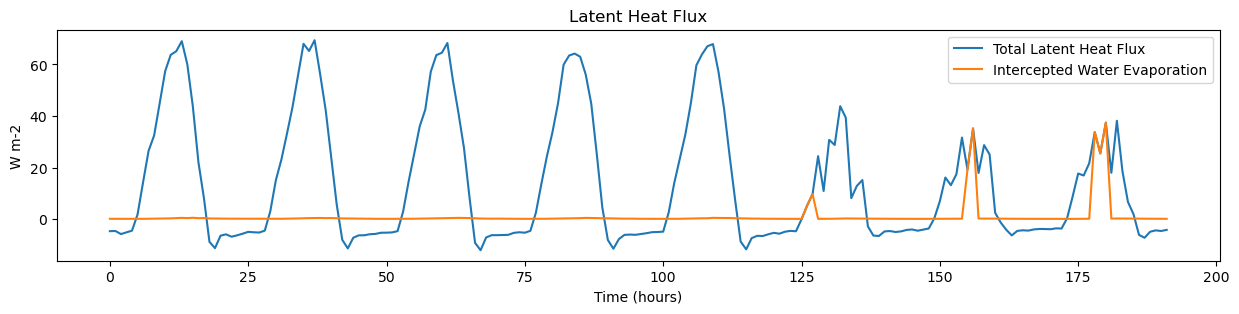

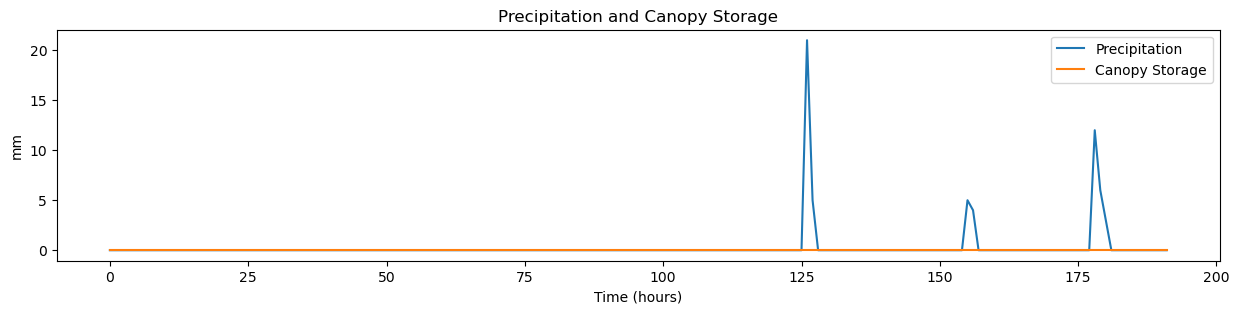

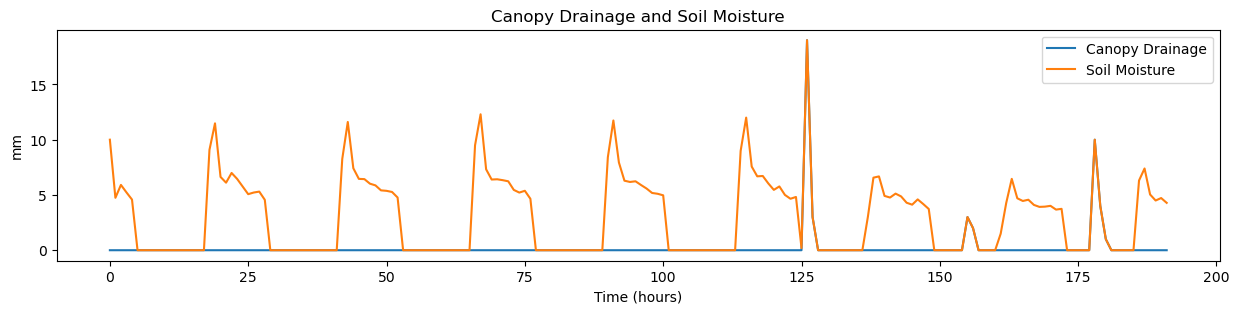

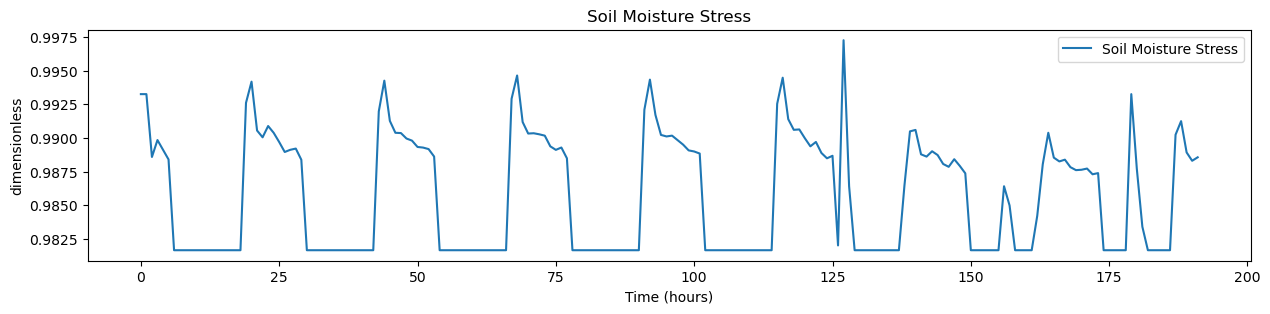

,Day,Rn,lambdaE,H,lambdaEl (C=Cactual),Bowen Ratio,Fractional Contribution
0,0,116.27,18.28,97.99,0.23,5.36,0.01
1,1,116.76,18.06,98.70,0.22,5.46,0.01
2,2,114.91,18.02,96.89,0.23,5.38,0.01
3,3,114.34,17.86,96.47,0.22,5.40,0.01
4,4,117.00,18.13,98.87,0.23,5.45,0.01
5,5,62.60,7.03,55.57,0.75,7.91,0.11
6,6,60.90,6.85,54.06,2.38,7.90,0.35
7,7,74.10,8.12,65.98,4.14,8.13,0.51


In [38]:
plot_data(grass_data)

In [52]:
from IPython.display import display



def display_averages(df, caption):
    # Calculate daily averages, column is in cumulative hours
    df['Day'] = df['Total Hour'] // 24
    # Resetting the index here with as_index=False to keep 'Day' as a column
    daily_averages = df.groupby('Day', as_index=False).mean()

    # Calculate Bowen Ratio and Fractional Contribution
    daily_averages['Bowen Ratio'] = daily_averages['H'] / daily_averages['lambdaE']
    daily_averages['Fractional Contribution'] = daily_averages['lambdaEl (C=Cactual)'] / daily_averages['lambdaE']

    # Select the columns you want to display
    columns_to_display = ['Day', 'Rn', 'lambdaE', 'H', 'lambdaEl (C=Cactual)', 'Bowen Ratio', 'Fractional Contribution']

    # Style the DataFrame for better presentation
    styled_df = daily_averages[columns_to_display].style.set_table_styles(
        [{
            'selector': 'th',
            'props': [('text-align', 'center')]
        }],
        overwrite=False
    ).set_properties(**{'text-align': 'center'}).format(
        # Specify formatting for each column individually
        {"Day": "{:.0f}", "Rn": "{:.2f}", "lambdaE": "{:.2f}", "H": "{:.2f}", 
        "lambdaEl (C=Cactual)": "{:.2f}", "Bowen Ratio": "{:.2f}", "Fractional Contribution": "{:.2f}"}
    ).set_caption(caption) # Add caption here

    # Display the styled DataFrame
    display(styled_df)

display_averages(forest_data, "Forest")
display_averages(grass_data, "Grass")

,Day,Rn,lambdaE,H,lambdaEl (C=Cactual),Bowen Ratio,Fractional Contribution
0,0,206.07,33.29,172.78,1.61,5.19,0.05
1,1,206.05,32.68,173.37,1.57,5.30,0.05
2,2,205.44,33.10,172.33,1.63,5.21,0.05
3,3,205.25,32.91,172.34,1.58,5.24,0.05
4,4,206.02,32.83,173.19,1.62,5.28,0.05
5,5,118.63,14.05,104.58,1.78,7.44,0.13
6,6,114.18,13.30,100.88,4.73,7.59,0.36
7,7,135.70,15.52,120.18,6.93,7.74,0.45


,Day,Rn,lambdaE,H,lambdaEl (C=Cactual),Bowen Ratio,Fractional Contribution
0,0,116.27,18.28,97.99,0.23,5.36,0.01
1,1,116.76,18.06,98.70,0.22,5.46,0.01
2,2,114.91,18.02,96.89,0.23,5.38,0.01
3,3,114.34,17.86,96.47,0.22,5.40,0.01
4,4,117.00,18.13,98.87,0.23,5.45,0.01
5,5,62.60,7.03,55.57,0.75,7.91,0.11
6,6,60.90,6.85,54.06,2.38,7.90,0.35
7,7,74.10,8.12,65.98,4.14,8.13,0.51


In [39]:

# D.2 Canopy Transpiration.
#This section currently unused. Section D.1 used instead.

def calc_lambdaET_dry_D2(delta, Rn, ra, rs, psy_const, rho_a, Dref):
    """
    Calculate transpiration rate
    delta: gradient of the saturation vapor pressure curve in kPa/°C
    Rn: net radiation in W/m^2
    ra: aerodynamic resistance in s/m
    psy_const: psychrometric constant in kPa/°C
    rho_a: air density in kg/m^3
    Dref: observed VPD at reference level above canopy in kPa
    return: transpiration rate in W/m^2
    """
    A = Rn # Available energy = net radiation problem statement D.2.1
    lambdaET_dry = delta * A + (rho_a * cp * Dref / ra) / (delta + psy_const * (1 + ra / rs)) # Eq 22.18 TH, problem statement D.2.1
    return lambdaET_dry

def calc_H_D2(Rn, lambdaET_dry):
    """
    Calculate turbulent sensible heat flux from net radiation, evaporation rate, and heat flux into the ground.
    R_n: Net radiation in W/m^2.
    E: Evaporation rate in m/s.
    G: Heat flux into the ground in W/m^2.
    return: Turbulent sensible heat flux in W/m^2.
    """
    H = Rn - lambdaET_dry # Given in problem statement D.2.2
    return H
